In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from tabulate import tabulate
from scipy import stats

from flaml import AutoML
from flaml.automl.data import get_output_from_log

from dython.nominal import associations
from mrmr import mrmr_regression, mrmr_classif

from scipy.stats import gaussian_kde

import statsmodels.api as sm

sklearn.set_config(transform_output="pandas")

import seaborn as sns

In [2]:
visits = pd.read_csv('Modified_Data/visits.csv')

## Preparing the data

In [3]:
id_columns = [col for col in visits.columns if '_id' in col]
print("We are dropping the following columns:", id_columns)
visits.drop(columns=id_columns, inplace=True)

We are dropping the following columns: ['visit_id', 'customer_id', 'transaction_id']


In [4]:
# drop columns 
visits.drop(columns=['start_timestamp', 'end_timestamp', 'user_first_name', 
                     'user_last_name', 'email', 'purchase_date', 'purchase_price', 
                     'release_date', 'month_year','switch_type'], inplace=True)

### Null values

In [5]:
visits.isna().sum()

visit_type                  0
visit_duration_time         0
gender                      0
email_domain             3787
platform               125546
user_review            398264
car_model              125546
fuel_type              125546
price                  125546
discount               125546
car_age_days           125546
purchased                   0
average_visit_time          0
visit_number                0
reviewed                    0
engaged                     0
loyalty                     0
dtype: int64

For now we don't care about those who didn't bought at least a car, so we are going to drop the nans

In [6]:
# drop the nans
visits.dropna(inplace=True)

In [7]:
y = visits['user_review']
X = visits.drop(columns=['user_review', 'reviewed'])

In [8]:
# get dummies
X = pd.get_dummies(X)
X.shape

(40308, 38)

## Analyse the features

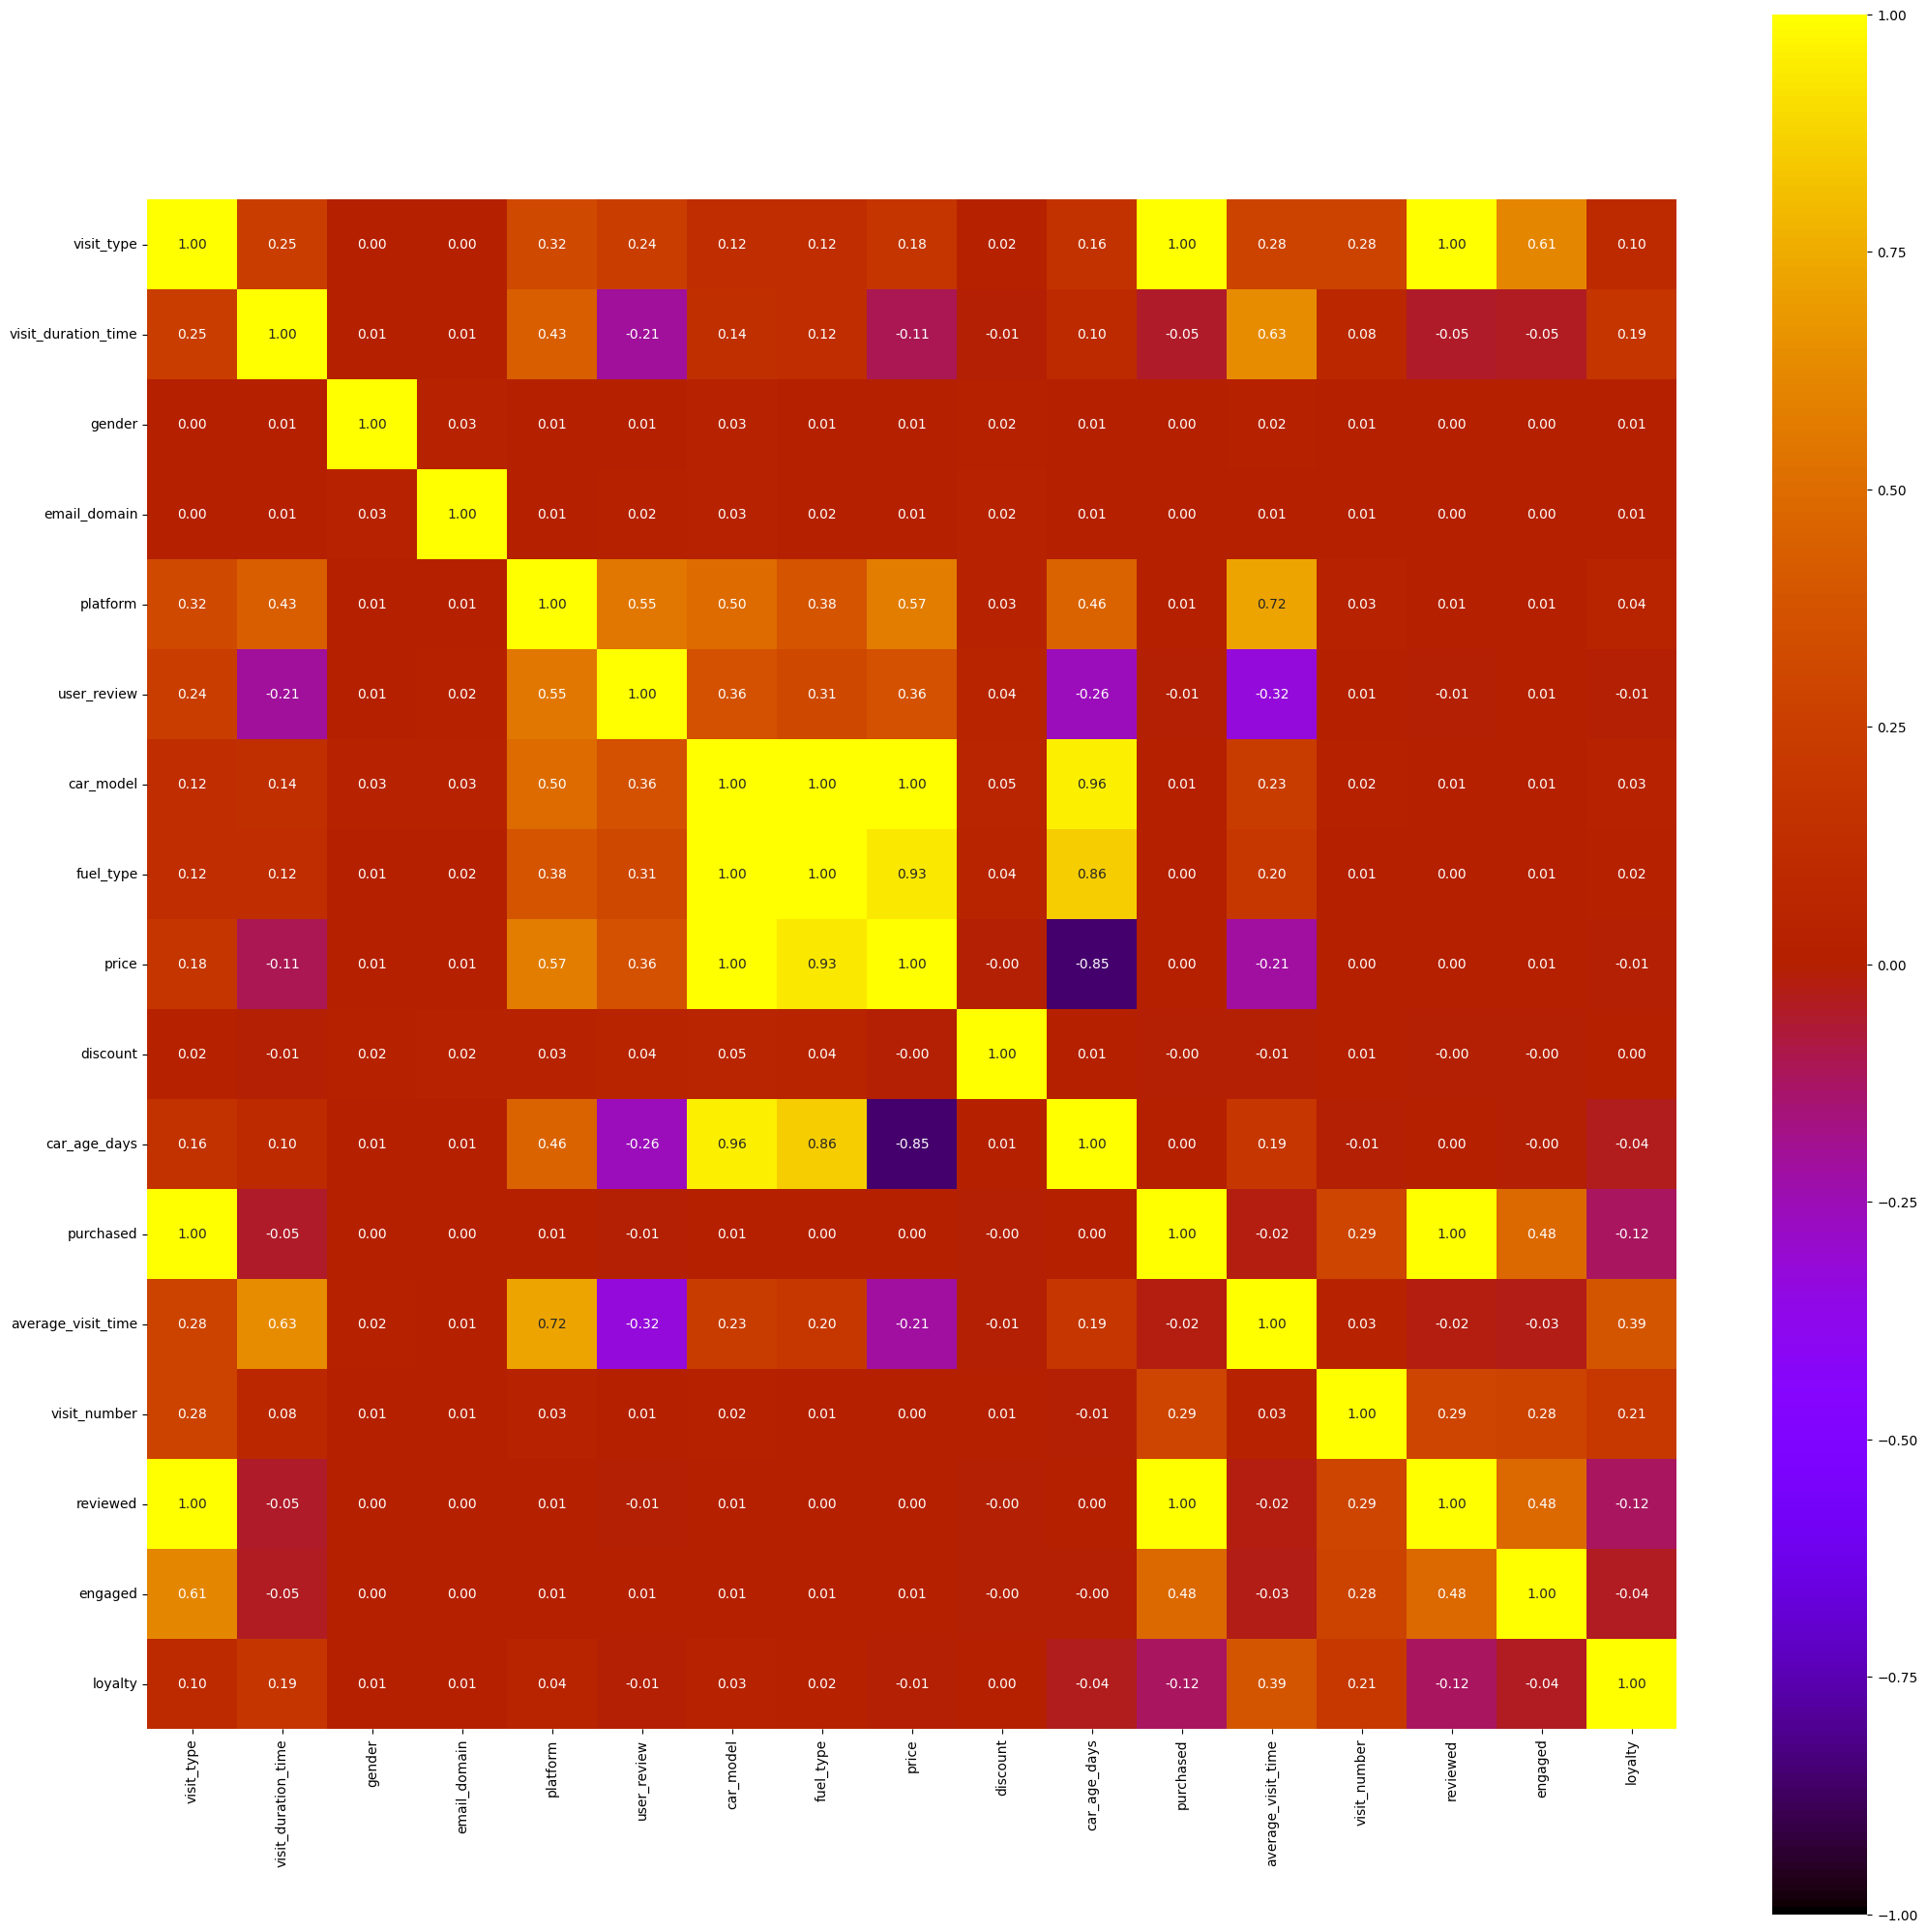

In [9]:
associations = associations(visits, multiprocessing=True, cmap='gnuplot', num_num_assoc='spearman')

In [10]:
selected_features = mrmr_classif(X=X, y=y, K=100)
print(selected_features)

100%|██████████| 38/38 [00:05<00:00,  7.10it/s]

['platform_Dealership', 'email_domain_yahoo.com', 'price', 'average_visit_time', 'platform_Website', 'platform_Mobile App', 'car_model_Model i8', 'fuel_type_Electric', 'visit_type_testing', 'fuel_type_Diesel', 'visit_duration_time', 'car_model_1 Series', 'car_age_days', 'visit_type_car configuration', 'gender_Other', 'discount', 'car_model_Sedan', 'email_domain_outlook.com', 'car_model_Model iX', 'car_model_Model M', 'loyalty', 'car_model_3 Series', 'email_domain_hotmail.com', 'visit_type_viewing', 'car_model_Model i7', 'fuel_type_Gasoline', 'car_model_Sierra', 'gender_Female', 'car_model_Tourer', 'car_model_Model iY', 'car_model_Touring', 'visit_number', 'email_domain_gmail.com', 'car_model_Coupe', 'gender_Male', 'engaged', 'purchased', 'visit_type_purchasing']


## Train

In [11]:
# creating the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
automl = AutoML()
automl.fit(X_train, y_train, task="regression", time_budget=1800 , metric="mape", log_file_name="user_review.log", eval_method="cv", n_splits=5, n_jobs=-1, verbose=3)

[flaml.automl.logger: 12-03 09:21:50] {1728} INFO - task = regression
[flaml.automl.logger: 12-03 09:21:50] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 12-03 09:21:50] {1838} INFO - Minimizing error metric: mape
[flaml.automl.logger: 12-03 09:21:50] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 12-03 09:21:50] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-03 09:21:51] {2393} INFO - Estimated sufficient time budget=6011s. Estimated necessary time budget=43s.
[flaml.automl.logger: 12-03 09:21:51] {2442} INFO -  at 0.9s,	estimator lgbm's best error=0.8045,	best estimator lgbm's best error=0.8045
[flaml.automl.logger: 12-03 09:21:51] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-03 09:21:51] {2442} INFO -  at 1.3s,	estimator lgbm's best error=0.8045,	best estimator lgbm's best error=0.8045
[flaml.automl.logger: 12-03 09:21:51] {2258} 

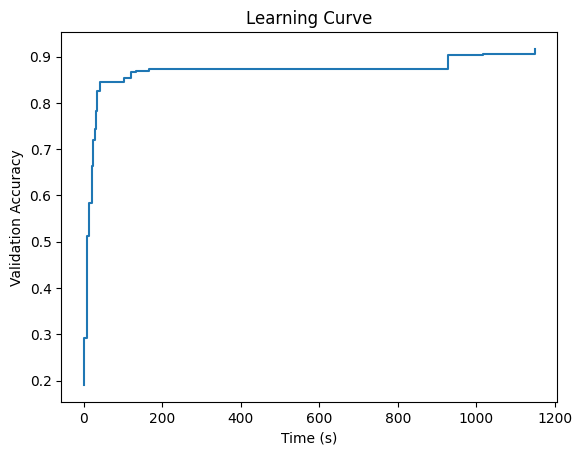

Best Configuration based on the best validation loss:
lgbm
{'n_estimators': 35, 'num_leaves': 21061, 'min_child_samples': 2, 'learning_rate': 0.31074516453133305, 'log_max_bin': 9, 'colsample_bytree': 0.755171718871668, 'reg_alpha': 0.02499909814687708, 'reg_lambda': 0.0009765625}


In [ ]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename="user_review.log", time_budget=7200)

plt.title("Learning Curve")
plt.xlabel("Time (s)")
plt.ylabel("Validation Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()


# Find the index of the best validation loss
best_index = np.argmin(best_valid_loss_history)

# Get the best configuration from the config history
best_config = config_history[best_index]

learner_name = best_config["Current Learner"]
hyperparameters = best_config["Current Hyper-parameters"]

# print the best configuration as a dictionary
print("Best Configuration based on the best validation loss:")
print(best_config["Current Learner"])
print(best_config["Current Hyper-parameters"])

In [ ]:
try:
    plt.barh(automl.model.estimator.feature_name_, automl.model.estimator.feature_importances_)
except Exception as e:
    print(e)
    pass

'NoneType' object has no attribute 'estimator'


In [ ]:
# get the most useful features
print(tabulate(sorted(zip(automl.model.estimator.feature_importances_, X.columns), reverse=True)))

AttributeError: 'NoneType' object has no attribute 'estimator'

## Results

In [ ]:
y_pred = automl.predict(X_test)

In [ ]:
residuals = y_test - y_pred

mae = mean_absolute_error(y_test, y_pred)
nmae=((np.nansum(abs(residuals)))/(np.nansum(abs(np.nanmean(y_test)-(y_test)))))
mape = np.nanmean(abs(residuals / y_test)) * 100
rmse = mean_squared_error(y_test, y_pred, squared=False)
#nrmse = rmse/(y_test.mean())
nrmse = rmse/(y_test.max() - y_test.min())
rsq = r2_score(y_test, y_pred)
rho, __ = stats.spearmanr(y_test, y_pred)

metrics_dict = {'Mean Absolute Error': float(mae),
                'Normalized Mean Absolute Error': float(nmae),
                'Mean Absolute Percentage Error': float(mape),
                'Root Mean Squared Error': float(rmse),
                'Normalized Root Mean Squared Error': float(nrmse),
                'R2 score': float(rsq),
                'Spearman correlation (rho)': float(rho)}

print(tabulate(metrics_dict.items(), headers=['Metric', 'Value'], tablefmt='pretty'))

+------------------------------------+---------------------+
|               Metric               |        Value        |
+------------------------------------+---------------------+
|        Mean Absolute Error         | 0.11497100043985253 |
|   Normalized Mean Absolute Error   | 0.05100951947541201 |
|   Mean Absolute Percentage Error   |  2.82238969165268   |
|      Root Mean Squared Error       | 0.41472064437801043 |
| Normalized Root Mean Squared Error | 0.04608007159755671 |
|              R2 score              | 0.9771829488845947  |
|     Spearman correlation (rho)     | 0.9782751227604024  |
+------------------------------------+---------------------+


In [ ]:
density = gaussian_kde(np.stack([y_pred, y_test]))(np.stack([y_pred, y_test]))

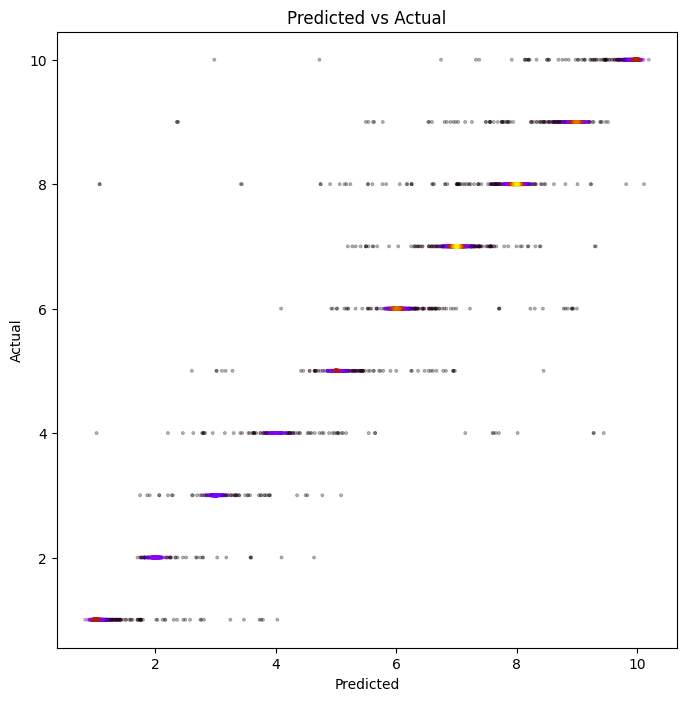

In [ ]:
# un grafico per i residui che è composto da uno scatterplot sovrapposto ad un hexbin plot
def hexbin_scatter_plot(x_axis_data, y_axis_data, x_label_name, y_label_name, title_name, hexbin_color_palette, scatter_color, scatter_alpha,point_size=1, figsize=(7, 7)):
    plt.figure(figsize=figsize)
    plt.hexbin(x_axis_data, y_axis_data, gridsize=50, cmap=hexbin_color_palette)
    plt.scatter(x_axis_data, y_axis_data, color=scatter_color, alpha=scatter_alpha, s=point_size)
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    plt.show()

# li grafico uno accanto all'altro
plt.figure(figsize=(8, 8))
plt.scatter(y_pred, y_test, s=5, alpha=0.3, linewidths=0.5, c=density, cmap="gnuplot")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual")

residuals =  y_test - y_pred
#hexbin_scatter_plot(y_pred, y_test, "Predicted", "Actual", "Actual vs Predicted", "gnuplot", "white", scatter_alpha=0, point_size=0.3)

In [ ]:
residuals = y_test - y_pred
sdev_resid = np.std(residuals)
standardized_residuals = residuals / sdev_resid

Text(0.5, 0.98, 'Residual QQ Plot')

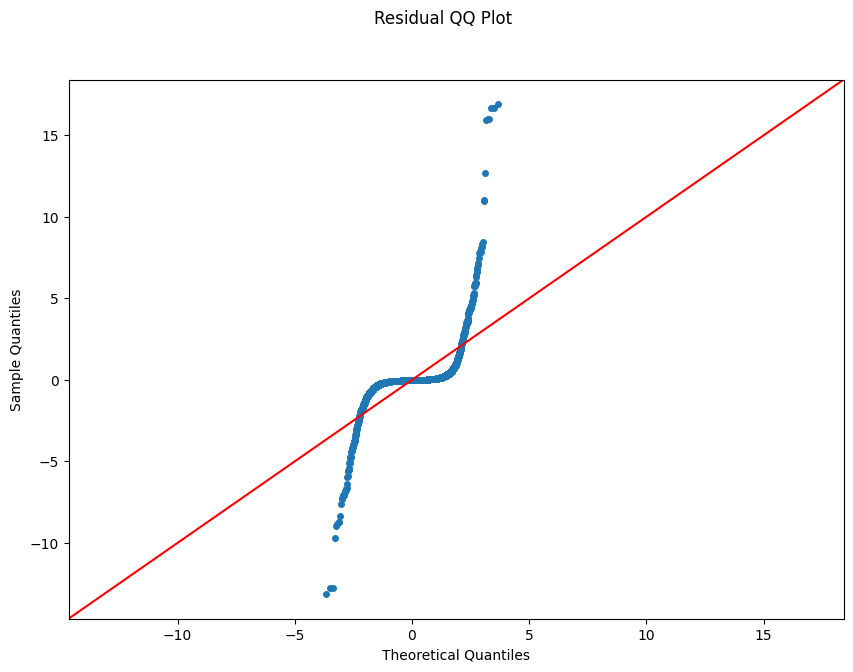

In [ ]:
# QQ Plot
fig, ax = plt.subplots(figsize=(10, 7))
pp = sm.ProbPlot(standardized_residuals, fit=True)
pp.qqplot(marker='o', ms = 4, color = 'tab:blue', line='45', ax=ax)
fig.suptitle('Residual QQ Plot', fontsize=12)

In [ ]:
for feature in X_test.columns:     
    fig = plt.figure(figsize=[10, 7])

    # unique values of the feature
    unique_values = X_test[feature].unique()
    
    if pd.api.types.is_numeric_dtype(X_test[feature]) and len(unique_values) > 5:
        ax = fig.add_subplot(111)
        ax.scatter(X_test[feature], standardized_residuals)
        ax.axhline(y=0, color='black', linestyle=':')
        ax.axhline(y=3, color='red', linestyle='--')
        ax.axhline(y=-3, color='red', linestyle='--')

    elif pd.api.types.is_string_dtype(X_test[feature]) or len(unique_values) <= 5:
        # if numeric convert to string
        if pd.api.types.is_numeric_dtype(X_test[feature]):
            X_test[feature] = X_test[feature].astype(str)
        ax = sns.boxplot(x=X_test[feature], y=standardized_residuals, notch=True)
        #ruoto le etichette di 45 gradi
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.axhline(y=3, color='red', linestyle='--')
        ax.axhline(y=-3, color='red', linestyle='--')

    ax.set_xlabel(f"{feature}".lower())
    ax.set_ylabel("Standardized Residual")
    ax.set_title(f"'{feature}' vs Stand. Residual", fontsize=14)